In [2]:
#Pytorch Project 1
#Image Classification (Multi classification of Animal Faces)

In [3]:
!pip install opendatasets --quiet
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/andrewmvd/animal-faces'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: vedantnadgir
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:06<00:00, 117MB/s]


In [4]:
import torch
import torch.nn as nn ##Neural Network
from torch.optim import Adam ##Optimizer for training
from torchvision.transforms import transforms #In preprocessing images
from torch.utils.data import Dataset, DataLoader #To create custom datasets and loop through the batches
from sklearn.preprocessing import LabelEncoder # Preprocessing Labelencoder to convert our labels from string to int
from PIL import Image # To read the images
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os #To read from the directory
device = 'cuda' if torch.cuda.is_available() else 'cpu' #T4 GPU is cuda and pytorch has to identify it
print(device)

cuda


In [5]:
image_path = []
labels = []#Collection of Labels in the order of image path
for i in os.listdir("/content/animal-faces/afhq"):#val or train
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"):#cat or dog or wild
    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):#Each individual images
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")
      labels.append(label)
data_df = pd.DataFrame(zip(image_path,labels), columns = ['image_path','labels'])
print(data_df['labels'].unique())
data_df.head()

['dog' 'wild' 'cat']


,image_path,labels
0,/content/animal-faces/afhq/val/dog/pixabay_dog...,dog
1,/content/animal-faces/afhq/val/dog/pixabay_dog...,dog
2,/content/animal-faces/afhq/val/dog/pixabay_dog...,dog
3,/content/animal-faces/afhq/val/dog/pixabay_dog...,dog
4,/content/animal-faces/afhq/val/dog/flickr_dog_...,dog


In [6]:
#Split the dataset into 3 dataframe(train-validation-test)
train = data_df.sample(frac = 0.7)#A sample of 70% of the main dataFrame to be train
test = data_df.drop(train.index)#Dropped the train data so remaining will be test
val = test.sample(frac = 0.5)
test = test.drop(val.index)
print(train.shape,val.shape,test.shape)


(11291, 2) (2420, 2) (2419, 2)


In [7]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df['labels']) #encodes all unique labels
transforms = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [8]:
class CustomImageDataset(Dataset):
  def __init__(self,dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)
  def __len__(self):
    return self.dataframe.shape[0]
  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx,0]
    label = self.labels[idx]
    image = Image.open(img_path).convert('RGB')
    if self.transform:
      image = self.transform(image).to(device)
    return image,label

In [9]:
train_dataset = CustomImageDataset(dataframe=train, transform = transforms)
val_dataset = CustomImageDataset(dataframe=val, transform = transforms)
test_dataset = CustomImageDataset(dataframe=test, transform = transforms)

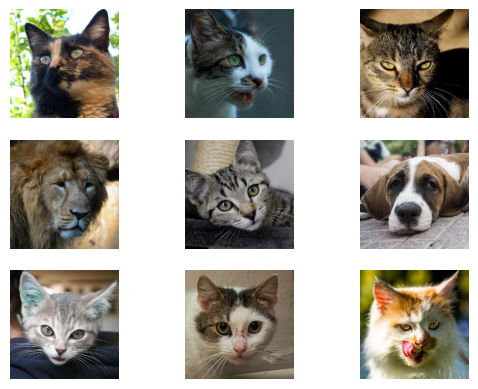

In [10]:
n_rows=3
n_cols =3
f,axarr = plt.subplots(n_rows,n_cols)
for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(data_df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
    axarr[row,col].imshow(image)
    axarr[row,col].axis('off')
plt.show()

In [11]:
#Setting Hyperparameters
LR = 1e-4 #Learning rate
BATCH_SIZE = 16
EPOCHS = 11

In [12]:
#Now To build data Loaders--> Used to loop through out data to feed the model
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
class Net(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1) # First Convolution layer
      self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1) # Second Convolution layer
      self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1) # Third Convolution layer
      self.pooling = nn.MaxPool2d(2,2) # The pooling layer, we will be using the same layer after each conv2d.
      self.relu = nn.ReLU() # ReLU Activation function

      self.flatten = nn.Flatten() # Flatten and vectorize the output feature maps that somes from the final convolution layer.
      self.linear = nn.Linear((128 * 16 * 16), 128) # Traditional Dense (Linear)
      self.output = nn.Linear(128, len(data_df['labels'].unique())) # Output Linear Layer


    def forward(self, x):
      x = self.conv1(x) # -> Outputs: (32, 128, 128)
      x = self.pooling(x)# -> Outputs: (32, 64, 64)
      x = self.relu(x)
      x = self.conv2(x) # -> Outputs: (64, 64, 64)
      x = self.pooling(x) # -> Outputs: (64, 32, 32)
      x = self.relu(x)
      x = self.conv3(x) # -> Outputs: (128, 32, 32)
      x = self.pooling(x) # -> Outputs: (128, 16, 16)
      x = self.relu(x)
      x = self.flatten(x)
      x = self.linear(x)
      x = self.output(x)

      return x

model = Net().to(device) # Create an instance of the model and move it to the GPU Device

In [14]:
from torchsummary import summary
summary(model, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [15]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss
optimizer = Adam(model.parameters(), lr=LR) # Adam optimizer

In [17]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []


for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))
  print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}
              Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/val_dataset.__len__() * 100, 4)}''')
  print("="*25)

KeyboardInterrupt: 

In [18]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")

Accuracy Score is: 96.7342 and Loss is 0.0182


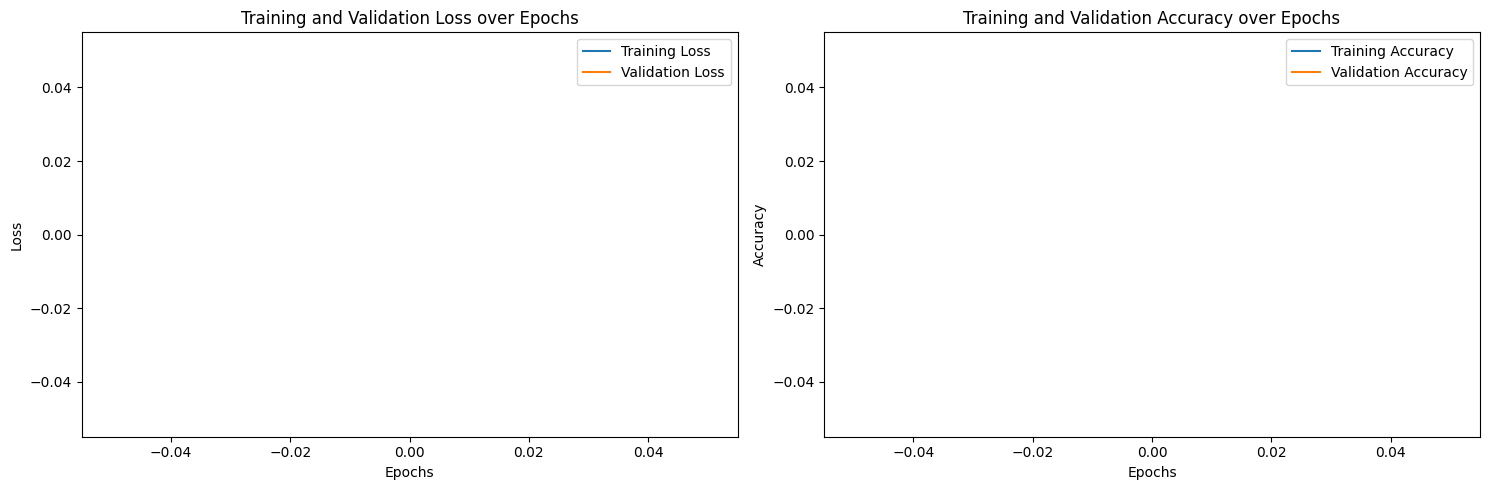

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

In [20]:
# 1- read image
# 2- Transform using transform object
# 3- predict through the model
# 4- inverse transform by label encoder

def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return label_encoder.inverse_transform([output])

## Visualize the image
image = Image.open("/content/cute-photos-of-cats-looking-at-camera-1593184780.jpg")
plt.imshow(image)
plt.show()


## Predict
print()
print("Prediction: \n")
predict_image("/content/cute-photos-of-cats-looking-at-camera-1593184780.jpg")

FileNotFoundError: [Errno 2] No such file or directory: '/content/cute-photos-of-cats-looking-at-camera-1593184780.jpg'